# File to train the network for the app

Going to import the necessary library

In [1]:
import Model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm 
import time
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import librosa
import DataGeneration as dg
import python_speech_features as sf

tf.enable_eager_execution()
print(tf.executing_eagerly())
print(tf.__version__)
print(tf.keras.__version__)

Using TensorFlow backend.


True
1.14.0
2.2.4-tf


Going to set some variables and retrive the list for the train, validation and test sets.

In [2]:
# Root folder for the dataset
dataset_dir = "Dataset/"

# Files for the validation and test sets.
val_file = 'validation_list.txt'
test_file = 'testing_list.txt'

# Dictionary containing the mapping between category name and label
DictCategs = {'nine' : 1, 'yes' : 2, 'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 
              'stop' : 10, 'go' : 11, 'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 
              'six' : 18, 'seven' : 19, 'eight' : 20, 'backward':21, 'bed':22, 'bird':23, 'cat':24, 'dog':25, 'follow':26, 
              'forward':27, 'happy':28, 'house':29, 'learn':30, 'marvin':31, 'sheila':32, 'tree':33, 'visual':34, 'wow':0 }

# Number of the categories 
nCategs = 35

# Method that return the train, validation and test sets with their labels 
data = dg.DataGeneration(dataset_dir, DictCategs, nCategs)
train, trainLabels, val, valLabels, test, testLabels = data.create_data(test_file, val_file)

Loading of the train set:
0/84843
5000/84843
10000/84843
15000/84843
20000/84843
25000/84843
30000/84843
35000/84843
40000/84843
45000/84843
50000/84843
55000/84843
60000/84843
65000/84843
70000/84843
75000/84843
80000/84843
84843/84843
Loading of the validation set:
0/9981
5000/9981
9981/9981
Loading of the test set:
0/11005
5000/11005
10000/11005
11005/11005


Example of WAV file for for the networks 

File: three/2aca1e72_nohash_0.wav.npy - Label: 15


Text(0.5, 1.0, 'WAV signal')

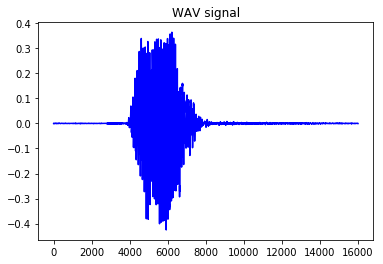

In [3]:
index = 2345
print("File: " + train[index] + " - Label: " + str(trainLabels[index]))

# Plot a wav
file_name = train[index]
wav = dg.DataGeneration.load_data(dataset_dir, file_name)

plt.figure()
plt.plot(wav, color='b')
plt.title('WAV signal')

Example of preprocessing (extraction of the log mel filterbanks

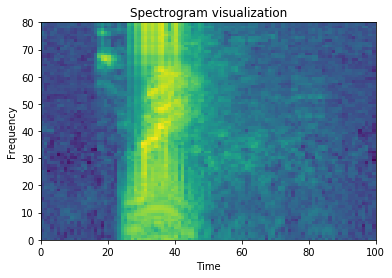

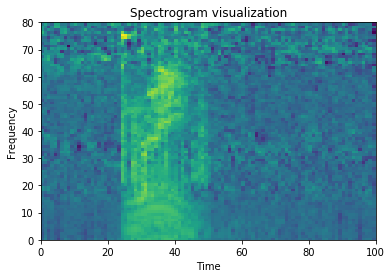

In [4]:
feats = dg.DataGeneration.load_and_preprocess_data(dataset_dir, train[index], False)
feats_noisy = dg.DataGeneration.preprocesing_noisy(wav, dataset_dir)
#print(feats.shape)
feats = np.transpose(feats)
feats_noisy = np.transpose(feats_noisy)
plt.figure()
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.figure()
plt.pcolormesh(feats_noisy)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
#print(feats)

Creation of the datasets for the training part

In [5]:
batch_size = 128

train_dataset = dg.DataGeneration.create_dataset_noisy(dataset_dir, train, trainLabels, 
                                                 batch_size = batch_size, 
                                                 shuffle = True, 
                                                 cache_file = 'trainnoisy_cache_Attention_35class')

val_dataset = dg.DataGeneration.create_dataset_noisy(dataset_dir, val, valLabels, 
                                               batch_size = batch_size, 
                                               shuffle = False, 
                                               cache_file = 'valnoisy_cache_Attention_35class')

test_dataset = dg.DataGeneration.create_dataset_noisy(dataset_dir, test, testLabels, 
                                                batch_size = batch_size, 
                                                shuffle = False, 
                                                cache_file = 'testnoisy_cache_Attention_35class')

train_steps = int(np.ceil(len(train) / batch_size))
val_steps = int(np.ceil(len(val) / batch_size))
test_steps = int(np.ceil(len(test) / batch_size))

print("steps to completa a train epoch: " + str(train_steps))
print("steps to completa a validation spoch: " + str(val_steps))
print("steps to completa a test epoch: " + str(test_steps))

steps to completa a train epoch: 663
steps to completa a validation spoch: 78
steps to completa a test epoch: 86


# CNN (no paper) + 2 RNN (no state) + MultyAttention with Diff   

In [6]:
model = Model.NewAttentionModelOurs(nCategs, 100, 80, 64, dropout = 0.0, activation = 'relu')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 4)   200         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 80, 4)   16          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 80, 4)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, verbose = 1)
checkpointer = ModelCheckpoint('Model/NoisyMultyAttentionDiff-checkpoint.h5', 
                               monitor = 'val_sparse_categorical_accuracy', 
                               verbose = 1, save_best_only = True, save_weights_only = True)

In [8]:
learning_rate = 0.00002

adam = tf.train.AdamOptimizer(learning_rate, 
                              beta1 = 0.9,
                              beta2 = 0.999,
                              epsilon = 1e-07,
                              use_locking = False,
                              name = 'Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

model.load_weights('Model/NoisyMultyAttentionDiff-checkpoint.h5')
#epoca 1: train 52.21 - val 75.75
#epoca 2: train 78.27 - val 85.48
#epoca 3: train 84.47 - val 87.88 (tolto drop out)
#epoca 4: train 87.71 - val 88.67 (ridotto lr da 0.001 a 0.0005)
#epoca 5: train 88.36 - val 89.24 
#epoca 6: train 89.93 - val 90.76 (rimosso la l2 regularization, ridotto lr da 0.0005 a 0.0001)
#epoca 7: train 90.25 - val 90.76
#epoca 8: train 90.52 - val 91.22 (ridotto lr da 0.0001 a 0.00005)
#epoca 9: train 90.77 - val 91.01(ridotto lr da 0.00005 a 0.00002)

In [9]:
num_epochs = 1
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps,
                    callbacks = [checkpointer, earlystopper])

W0722 21:46:47.063461 140376917296896 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


662/663 [============================>.] - ETA: 5s - loss: 0.3070 - sparse_categorical_accuracy: 0.9077 
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.91006, saving model to Model/NoisyMultyAttentionDiff-checkpoint.h5
663/663 [==============================] - 3509s 5s/step - loss: 0.3071 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.2970 - val_sparse_categorical_accuracy: 0.9101


In [ ]:
#model.save_weights('Model/NoisyMultyAttentionDiff-e8-90-91weights.h5')
#model.save('Model/NoisyMultyAttentionDiff-e8-90-91.h5')

In [ ]:
res = model.evaluate(test_dataset, steps = test_steps)

index = 111
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
sol = model.predict(x_in)
#print(sol*100)
print(test[index] + " - Label: " + str(testLabels[index]))
print("Predict: " + str(np.argmax(sol)))

# Some plots 

## Confusion matrix 

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_dataset, steps = test_steps, verbose = 1)

classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 
           'four', 'five', 'six', 'seven', 'eight', 'backward', 'bed', 'bird', 'cat', 'dog', 'follow', 'forward', 'happy',
           'house', 'learn', 'marvin', 'sheila', 'tree', 'visual', 'wow']

cm = confusion_matrix(testLabels, np.argmax(y_pred[0:11005], 1))

dg.DataGeneration.plot_confusion_matrix(cm,classes, normalize=True, filename="Images/MultyAttentionDouglasConfusionMatrix.png")

## Attention Weights

In [ ]:
plotModel = tf.keras.Model(inputs=model.input, outputs=[model.get_layer('output').output,
                                                        #model.get_layer('attSoftmax').output, # only for singol attention
                                                        model.get_layer('attSoftmaxFirst').output, # only for multy attention models 
                                                        model.get_layer('attSoftmaxSecond').output, # only for multy attention models
                                                        model.get_layer('squeeze_last_dim').output])

In [ ]:
index = 1247
x_in = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False).reshape((1, 100, 80, 1))
outs, attW1, attW2, feature = plotModel.predict(x_in) #only for multy attention models
#outs, attW1, feature = plotModel.predict(x_in)

# Plot a wav
wav = dg.DataGeneration.load_data(dataset_dir, test[index])

plt.figure(figsize=(17,15))
plt.plot(wav, color='b')
plt.savefig('Images/picWAV.png', dpi = 400)
plt.title('WAV signal')

#print(attW.shape)
plt.figure(figsize=(17, 15))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
#plt.plot(np.log(attW[0, :]+1e-8))
plt.plot(attW1[0, :], 'b')
plt.plot(attW2[0, :], 'r') # only for multy attention models
#plt.plot(attW1[0, :] - attW2[0, :], 'g') #only for diff attention
plt.savefig('Images/MultyAttentionDouglasAttentionWeights.png', dpi = 400)
plt.show()

feature = np.transpose(feature.reshape((100, 80)))
plt.figure(figsize=(17,15))
plt.pcolormesh(feature)
plt.savefig('Images/MultyAttentionDouglasFeaturesExtracted.png', dpi = 400)

feats = dg.DataGeneration.load_and_preprocess_data(dataset_dir, test[index], False)
feats = np.transpose(feats)
plt.figure(figsize=(17,15))
plt.pcolormesh(feats)
plt.savefig('Images/picInput.png', dpi = 400)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()